In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df= pd.read_excel(r"C:\Users\Manjari\OneDrive - instancia consultancy\Tajamul\Online_Retail_RFM.xlsx")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df["Country"].value_counts()

In [ ]:
df.drop("StockCode",axis=1,inplace=True)
df.head()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   Description  540456 non-null  object        
 2   Quantity     541910 non-null  int64         
 3   InvoiceDate  541910 non-null  datetime64[ns]
 4   Price        541910 non-null  float64       
 5   Customer ID  406830 non-null  float64       
 6   Country      541910 non-null  object        
 7   Date         541910 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 33.1+ MB


In [16]:
#understanding/findin out each customers rec , freq and monetary values



#recenccy
day="2012-01-01"
day=pd.to_datetime(day)

recency=df.groupby(["Customer ID"]).agg({"InvoiceDate":lambda x:((day-x.max()).days)})
recency.head()

,InvoiceDate
Customer ID,
12346.0,347
12347.0,24
12348.0,97
12349.0,40
12350.0,332


In [24]:
#frequency


frequency=df.drop_duplicates(subset="Invoice").groupby(["Customer ID"])[["Invoice"]].count()
frequency.head(5)

,Invoice
Customer ID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [30]:
#monetary



df["total"]=df["Quantity"]*df["Price"]

In [32]:
monetary=df.groupby(["Customer ID"])[["total"]].sum()
monetary

,total
Customer ID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
...,...
18280.0,180.60
18281.0,80.82
18282.0,176.60


In [38]:
RFM=pd.concat([recency,frequency,monetary], axis=1)
recency.columns=["Recency"]
frequency.columns=["Frequency"]
monetary.columns=["Monetary"]
RFM

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,347,2,0.00
12347.0,24,7,4310.00
12348.0,97,4,1797.24
12349.0,40,1,1757.55
12350.0,332,1,334.40
...,...,...,...
18280.0,299,1,180.60
18281.0,202,1,80.82
18282.0,29,3,176.60


In [46]:

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

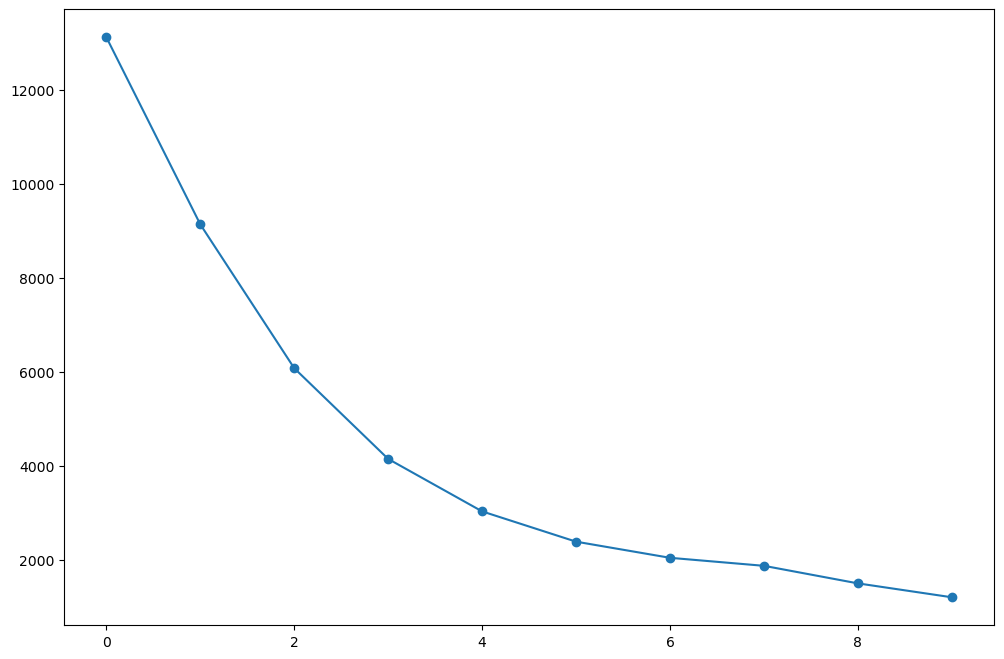

In [48]:
#Lets find the number of clusters present in the data
from sklearn.cluster import KMeans

inertia=[]

for i in np.arange(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(12,8))
plt.plot(inertia, marker="o")

In [54]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
RFM["Clusters"]=(kmeans.labels_+1)

In [75]:
RFM

,Recency,Frequency,Monetary,Clusters
Customer ID,,,,
12346.0,347,2,0.00,2
12347.0,24,7,4310.00,1
12348.0,97,4,1797.24,1
12349.0,40,1,1757.55,1
12350.0,332,1,334.40,2
...,...,...,...,...
18280.0,299,1,180.60,2
18281.0,202,1,80.82,2
18282.0,29,3,176.60,1


In [81]:
final=RFM.groupby("Clusters")[["Recency","Frequency","Monetary"]].mean()
final

,Recency,Frequency,Monetary
Clusters,,,
1,61.280431,5.748844,1939.561569
2,267.137466,1.852650,461.286245
3,28.428571,105.214286,106628.209286


Final Ranking (Best → Worst)

Cluster 3 → VIP Customers (recent, frequent, high spenders)

Cluster 1 → Regular Customers (active but not very high spenders)

Cluster 2 → Dormant Customers (inactive, low spending)

In [57]:
def func(row):
    if row["Clusters"] == 3:     # High value customers
        return 'Whales'
    elif row["Clusters"] == 2:   # Inactive/low spenders
        return 'Lapsed Cx'
    else:                        # Middle group
        return 'Avg. Cx'


In [59]:

RFM['group']=RFM.apply(func, axis=1)
RFM

,Recency,Frequency,Monetary,Clusters,group
Customer ID,,,,,
12346.0,347,2,0.00,2,Lapsed Cx
12347.0,24,7,4310.00,1,Avg. Cx
12348.0,97,4,1797.24,1,Avg. Cx
12349.0,40,1,1757.55,1,Avg. Cx
12350.0,332,1,334.40,2,Lapsed Cx
...,...,...,...,...,...
18280.0,299,1,180.60,2,Lapsed Cx
18281.0,202,1,80.82,2,Lapsed Cx
18282.0,29,3,176.60,1,Avg. Cx


In [63]:

result=RFM.group.value_counts().sort_values()
result

group
Whales         14
Lapsed Cx    1115
Avg. Cx      3243
Name: count, dtype: int64

<Axes: ylabel='group'>

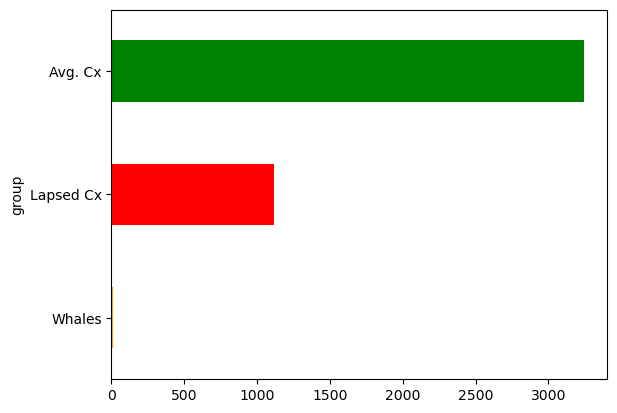

In [65]:
result.plot(kind="barh", color=["Orange","Red","Green"])

Dedicated customers are very low but average customers are huge. So we can target this and make them Premium.

Our focus should be on average customers and think about marketing strategies to convert them into Premium segment.